#  RNN - GRU

- Feature Engineering:

    -  Raw stock prices might not be enough. Include derived features like moving averages, RSI, MACD, Bollinger Bands, etc. Consider external data like market news, economic indicators, or sector performance.
- Normalization:

    - Stock data values often vary significantly. Normalize the features (e.g., Min-Max scaling or Z-score normalization) for better training.
- Sequence Length:

    - Stock market data has dependencies over various time horizons. Choose an appropriate sequence length to include past data that impacts predictions.
- Non-linearity and Noise:

    - Stock market data can be noisy and non-linear. Augment the GRU model with: Attention Mechanisms: To focus on the most relevant time steps. Dropout: To prevent overfitting.
- Evaluation Metrics:

    - Use appropriate metrics like Mean Absolute Percentage Error (MAPE) or directional accuracy (e.g., percentage of correct up/down movements) instead of plain MSE.
- Advanced Architectures:

    - Experiment with hybrid architectures like GRU combined with Convolutional Neural Networks (CNNs) for feature extraction from multiple sources.Consider Transformer models, which have shown strong performance on sequential tasks.
- Regularization:

    - Add L2 regularization or use techniques like weight decay to reduce overfitting.

In [1]:
#load libraires
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch

In [2]:
STOCKS_FOLDER = "stocks"
MACROECOMOMIC_US_FOLDER = "macroeconomic_us"
MACROECOMOMIC_GLOBAL_FOLDER = "macroeconomic_global"
COMMODITY_FOLDER = "commodity"


## Data Exploration and preparation

Used data:
- S&P 500 stock price 1992 - 2024
- CPI
- Retail Sales
- Unemployment

Additional indicators to use:
- Moving Averages (SMA, EMA)
- Relative Strength Index (RSI)
- Bollinger Bands
- MACD (Moving Average Convergence Divergence)
- Volume-related indicators (e.g., OBV - On Balance Volume)


In [3]:
sp500 = pd.read_csv(f"Train_Data/data.csv")
sp500.head()

,Unnamed: 0,Date,Open,High,Low,Close,Volume,pct_change,log_change,7sma,...,7lower,14upper,14middle,14lower,21upper,21middle,21lower,7cci,14cci,21cci
0,20,1992-01-30 00:00:00-05:00,3225.000000,3247.320068,3216.010010,3244.899902,22080000,0.006171,0.006152,3242.071991,...,3208.769750,3285.323041,3241.442871,3197.562701,3283.127814,3227.233340,3171.338867,-64.409996,-21.146668,30.876614
1,21,1992-01-31 00:00:00-05:00,3244.899902,3255.370117,3222.719971,3223.399902,20610000,-0.006626,-0.006648,3237.395627,...,3203.732631,3276.309967,3244.142857,3211.975747,3279.672097,3229.661912,3179.651727,-66.612483,-67.256807,16.990360
2,22,1992-02-03 00:00:00-05:00,3223.399902,3239.040039,3213.550049,3234.100098,18860000,0.003320,0.003314,3236.570641,...,3205.972650,3275.855201,3243.278582,3210.701963,3279.548735,3231.214297,3182.879860,-87.672273,-105.833293,-6.475713
3,23,1992-02-04 00:00:00-05:00,3234.100098,3272.810059,3229.429932,3272.800049,23970000,0.011966,0.011895,3245.637090,...,3203.782467,3279.706386,3244.300014,3208.893642,3284.053706,3234.676200,3185.298694,91.691723,98.026019,100.126289
4,24,1992-02-05 00:00:00-05:00,3272.800049,3282.199951,3251.790039,3257.600098,27360000,-0.004644,-0.004655,3248.630095,...,3205.337954,3280.899065,3244.871443,3208.843820,3285.545129,3237.190488,3188.835846,89.715961,109.020004,114.087410


In [4]:
sp500.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8039 entries, 0 to 8038
Data columns (total 34 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     8039 non-null   int64  
 1   Date           8039 non-null   object 
 2   Open           8039 non-null   float64
 3   High           8039 non-null   float64
 4   Low            8039 non-null   float64
 5   Close          8039 non-null   float64
 6   Volume         8039 non-null   int64  
 7   pct_change     8039 non-null   float64
 8   log_change     8039 non-null   float64
 9   7sma           8039 non-null   float64
 10  14sma          8039 non-null   float64
 11  21sma          8039 non-null   float64
 12  7macd          8039 non-null   float64
 13  7macd_signal   8039 non-null   float64
 14  14macd         8039 non-null   float64
 15  14macd_signal  8039 non-null   float64
 16  7rsi           8039 non-null   float64
 17  14rsi          8039 non-null   float64
 18  21rsi   

In [5]:
#display columns
print(sp500.columns)


Index(['Unnamed: 0', 'Date', 'Open', 'High', 'Low', 'Close', 'Volume',
       'pct_change', 'log_change', '7sma', '14sma', '21sma', '7macd',
       '7macd_signal', '14macd', '14macd_signal', '7rsi', '14rsi', '21rsi',
       '7atr', '14atr', '21atr', '7upper', '7middle', '7lower', '14upper',
       '14middle', '14lower', '21upper', '21middle', '21lower', '7cci',
       '14cci', '21cci'],
      dtype='object')


In [6]:
#remove white spaces from column names
sp500.columns = sp500.columns.str.strip()
print(sp500.columns)


Index(['Unnamed: 0', 'Date', 'Open', 'High', 'Low', 'Close', 'Volume',
       'pct_change', 'log_change', '7sma', '14sma', '21sma', '7macd',
       '7macd_signal', '14macd', '14macd_signal', '7rsi', '14rsi', '21rsi',
       '7atr', '14atr', '21atr', '7upper', '7middle', '7lower', '14upper',
       '14middle', '14lower', '21upper', '21middle', '21lower', '7cci',
       '14cci', '21cci'],
      dtype='object')


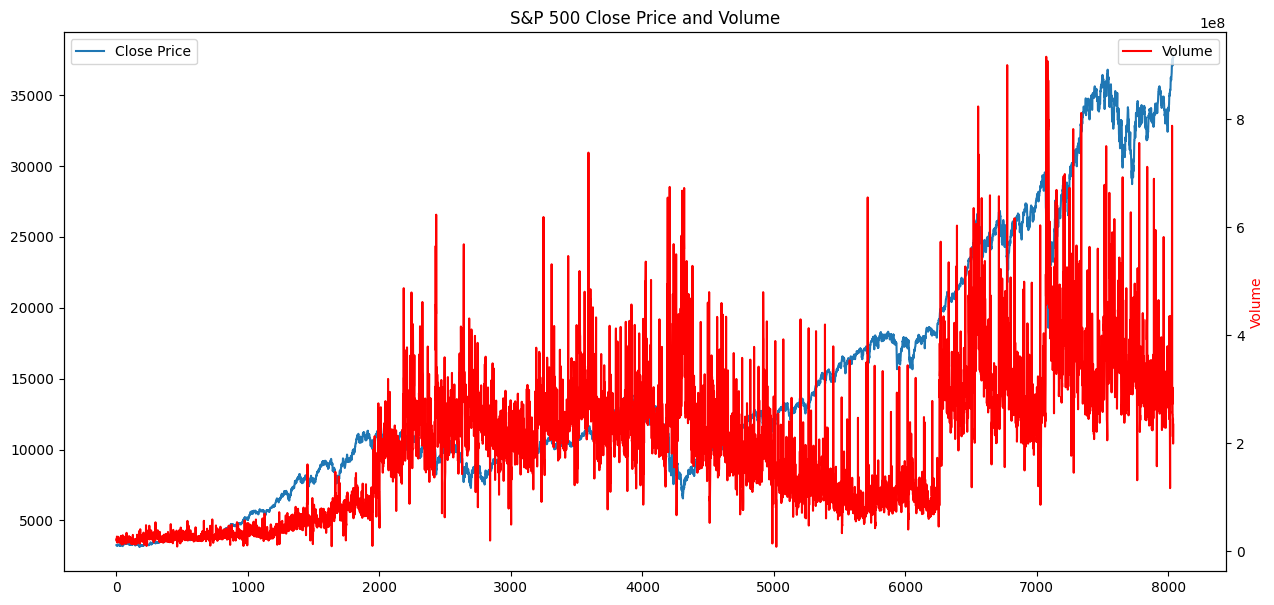

In [7]:
# visualize the data without date with volume overlaid
plt.figure(figsize=(15, 7))
plt.plot(sp500['Close'], label='Close Price')
plt.legend(['Close Price'], loc='upper left')
plt.twinx()
plt.plot(sp500['Volume'], color='r', label='Volume')
plt.title('S&P 500 Close Price and Volume')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.ylabel('Volume', color='r')
plt.legend(['Volume'], loc='upper right')
plt.show()


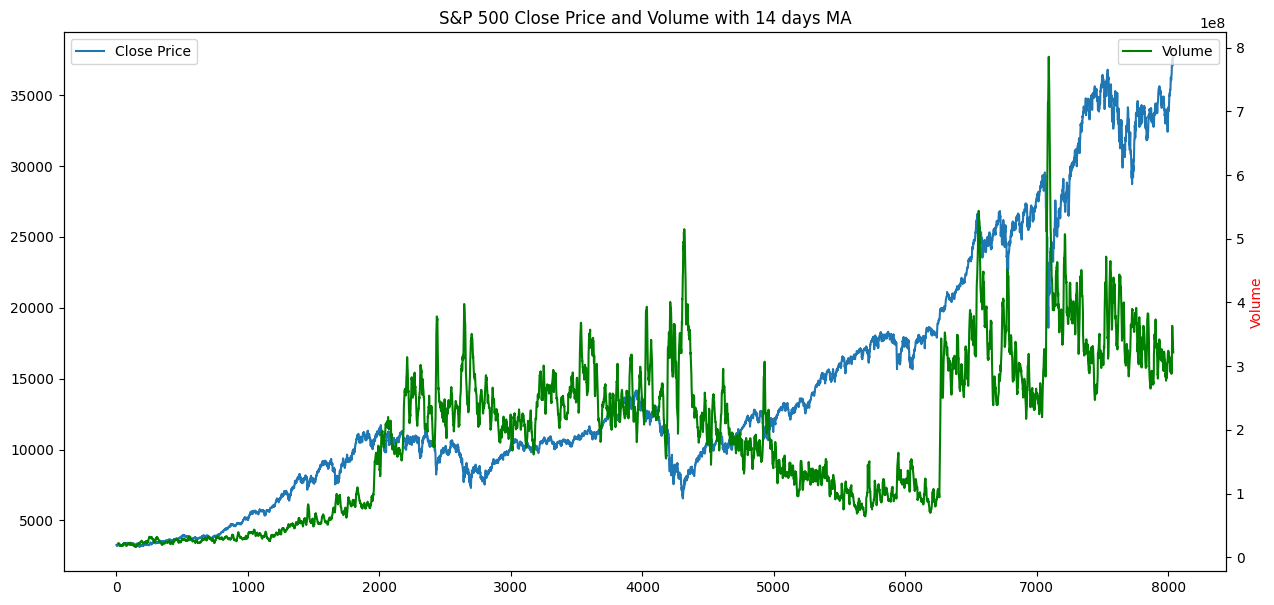

In [8]:
#visalaize the data with 14 days moving average of volume
plt.figure(figsize=(15, 7))
plt.plot(sp500['Close'], label='Close Price')
plt.legend(['Close Price'], loc='upper left')
plt.twinx()
#plt.plot(sp500['Volume'], color='r', label='Volume')
plt.plot(sp500['Volume'].rolling(14).mean(), color='g', label='14 days MA')
plt.title('S&P 500 Close Price and Volume with 14 days MA')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.ylabel('Volume', color='r')
plt.legend(['Volume', '14 days MA'], loc='upper right')
plt.show()


In [9]:
# drop NAN
sp500.dropna(inplace=True)
sp500.head()


,Unnamed: 0,Date,Open,High,Low,Close,Volume,pct_change,log_change,7sma,...,7lower,14upper,14middle,14lower,21upper,21middle,21lower,7cci,14cci,21cci
0,20,1992-01-30 00:00:00-05:00,3225.000000,3247.320068,3216.010010,3244.899902,22080000,0.006171,0.006152,3242.071991,...,3208.769750,3285.323041,3241.442871,3197.562701,3283.127814,3227.233340,3171.338867,-64.409996,-21.146668,30.876614
1,21,1992-01-31 00:00:00-05:00,3244.899902,3255.370117,3222.719971,3223.399902,20610000,-0.006626,-0.006648,3237.395627,...,3203.732631,3276.309967,3244.142857,3211.975747,3279.672097,3229.661912,3179.651727,-66.612483,-67.256807,16.990360
2,22,1992-02-03 00:00:00-05:00,3223.399902,3239.040039,3213.550049,3234.100098,18860000,0.003320,0.003314,3236.570641,...,3205.972650,3275.855201,3243.278582,3210.701963,3279.548735,3231.214297,3182.879860,-87.672273,-105.833293,-6.475713
3,23,1992-02-04 00:00:00-05:00,3234.100098,3272.810059,3229.429932,3272.800049,23970000,0.011966,0.011895,3245.637090,...,3203.782467,3279.706386,3244.300014,3208.893642,3284.053706,3234.676200,3185.298694,91.691723,98.026019,100.126289
4,24,1992-02-05 00:00:00-05:00,3272.800049,3282.199951,3251.790039,3257.600098,27360000,-0.004644,-0.004655,3248.630095,...,3205.337954,3280.899065,3244.871443,3208.843820,3285.545129,3237.190488,3188.835846,89.715961,109.020004,114.087410


## Hyperparameters


In [10]:
# hyperparameters
SEQ_LEN = 180
EPOCHS = 30
LR = 0.00001
HIDDEN_SIZE = 128
NUM_LAYERS = 2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


## Creating data loader for GRU NN - without macroecoomic data

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

class StockDataset(Dataset):
    def __init__(self, dataframe, seq_length=SEQ_LEN):
        self.data = dataframe
        self.seq_length = seq_length


        #    'log_change', '7sma', '14sma', '21sma', '7macd', '14macd', '7rsi',
        #    '14rsi', '21rsi', '7atr', '14atr', '21atr', '7upper', '7middle',
        #    '7lower', '14upper', '14middle', '14lower', '21upper', '21middle',
        #    '21lower', '7cci', '14cci', '21cci',

        self.Scaler = MinMaxScaler(feature_range=(0,1))
        self.data['Close'] = self.Scaler.fit_transform(self.data['Close'].values.reshape(-1, 1))
        self.data['Volume'] = self.Scaler.transform(self.data['Volume'].values.reshape(-1, 1))
        self.data['7sma'] = self.Scaler.transform(self.data['7sma'].values.reshape(-1, 1))
        self.data['14sma'] = self.Scaler.transform(self.data['14sma'].values.reshape(-1, 1))
        self.data['21sma'] = self.Scaler.transform(self.data['21sma'].values.reshape(-1, 1))
        self.data['7macd'] = self.Scaler.transform(self.data['7macd'].values.reshape(-1, 1))
        self.data['14macd'] = self.Scaler.transform(self.data['14macd'].values.reshape(-1, 1))



        # plot scaled data
        plt.figure(figsize=(15, 7))
        plt.plot(self.data['Close'], label='Close Price')
        plt.plot(self.data['7sma'], label='7sma')
        plt.legend(['Close Price', '7sma'], loc='upper left')
        plt.title('Scaled Close Price and 7sma')
        plt.xlabel('Time')
        plt.ylabel('Scaled Values')
        plt.show()
        
    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, index):
        # Add an extra dimension for input_size=2 (Close and 7sma)
        seq = torch.tensor(self.data[['Close', 'log_change', '7sma', '14sma', '21sma', '7macd', '14macd']].values[index: index + self.seq_length], dtype=torch.float32)
        target = torch.tensor(self.data['Close'].values[index + self.seq_length], dtype=torch.float32)  # Scalar target
        return seq, target


## Model definition for GRU 

In [12]:
import torch
import torch.nn as nn

class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout=0.0):
        super(GRUModel, self).__init__()
        
        # GRU layer
        self.gru = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0  # Apply dropout only for multi-layer GRU
        )
        
        # Fully connected layer for output
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        # Pass through GRU
        out, _ = self.gru(x)  # out: (batch_size, seq_len, hidden_size)
        
        # Extract the last time step's output for each sequence
        last_out = out[:, -1, :]  # (batch_size, hidden_size)
        
        # Pass the last hidden state through the fully connected layer
        output = self.fc(last_out)  # (batch_size, output_size)
        
        return output


C:\Users\Sebastian\AppData\Local\Temp\ipykernel_29176\2214211749.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['Close'] = self.Scaler.fit_transform(self.data['Close'].values.reshape(-1, 1))
C:\Users\Sebastian\AppData\Local\Temp\ipykernel_29176\2214211749.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['Volume'] = self.Scaler.transform(self.data['Volume'].values.reshape(-1, 1))
C:\Users\Sebastian\AppData\Local\Temp\ipykernel_29176\2214211749.py:22: SettingWithCopyWarning: 
A v

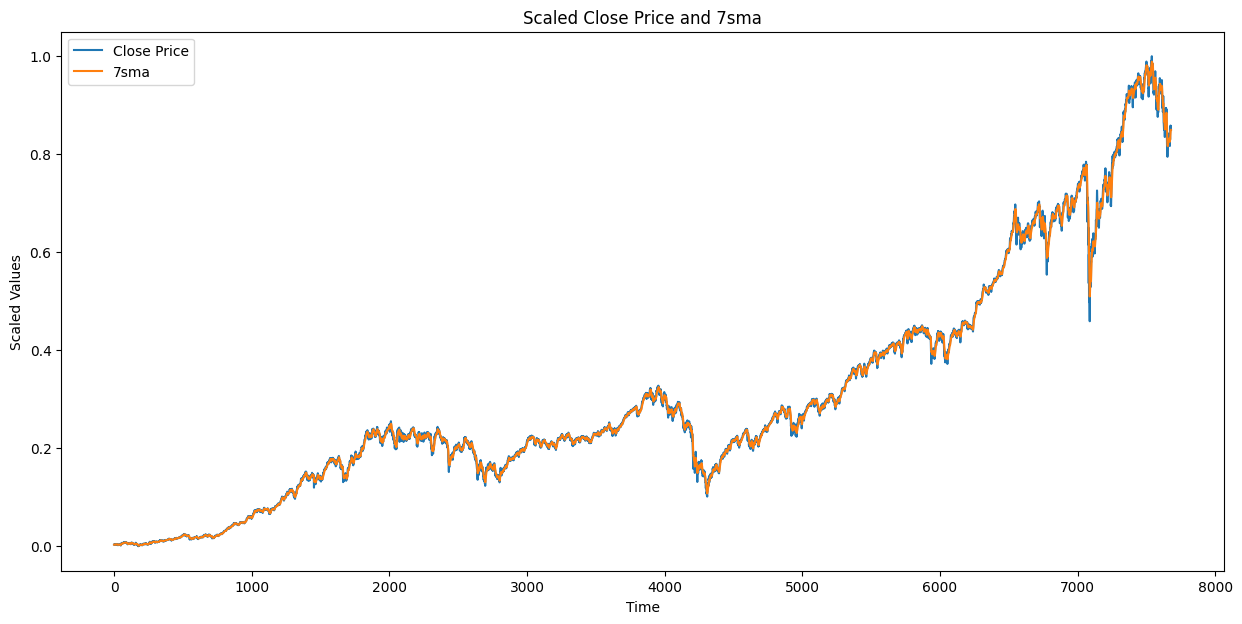

C:\Users\Sebastian\AppData\Local\Temp\ipykernel_29176\2214211749.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['Close'] = self.Scaler.fit_transform(self.data['Close'].values.reshape(-1, 1))
C:\Users\Sebastian\AppData\Local\Temp\ipykernel_29176\2214211749.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['Volume'] = self.Scaler.transform(self.data['Volume'].values.reshape(-1, 1))
C:\Users\Sebastian\AppData\Local\Temp\ipykernel_29176\2214211749.py:22: SettingWithCopyWarning: 
A v

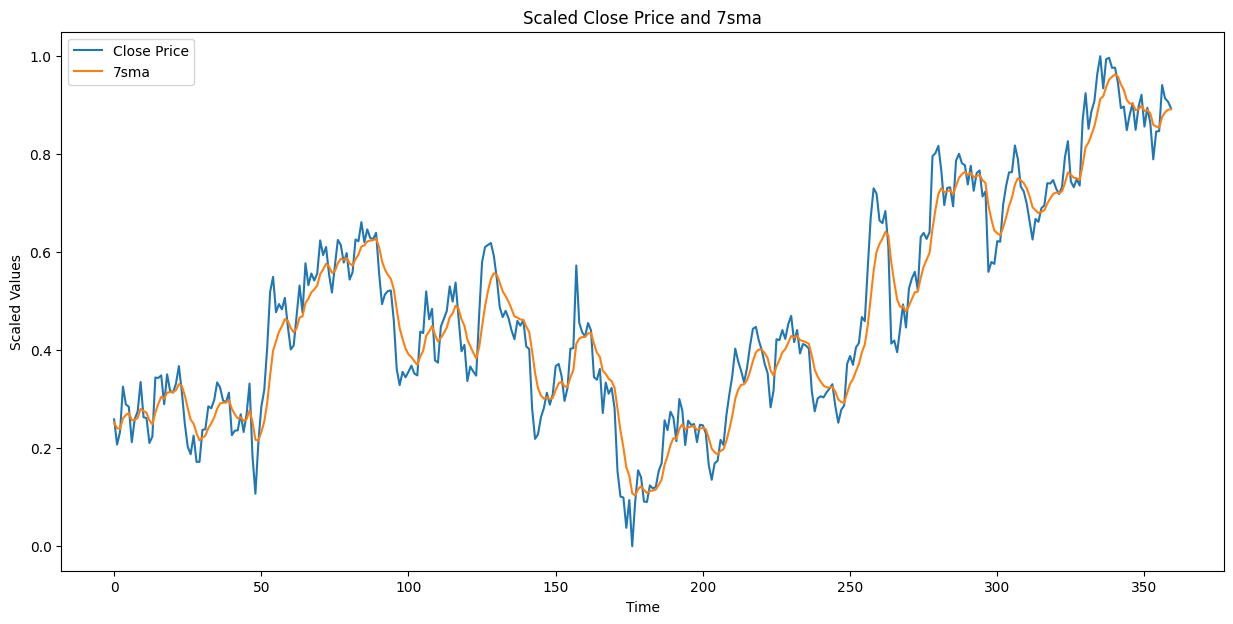

In [13]:
# oprtimizer, loss function, model and data loader instantiation
model = GRUModel(input_size=7, hidden_size=HIDDEN_SIZE, output_size=1, num_layers=NUM_LAYERS).to(device)
criterion = nn.MSELoss() # MSE loss
optimizer = optim.Adam(model.parameters(), lr=LR)

# Define dataloader
dataset = StockDataset(sp500[:-SEQ_LEN*2], SEQ_LEN)
dataset_test = StockDataset(sp500[:SEQ_LEN*2], SEQ_LEN)

dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
dataloader_test = DataLoader(dataset_test, batch_size=1, shuffle=False)


In [ ]:
# Training loop with early stopping and saving best weights based on training dataset improvement
model.to(device)
best_loss = float('inf')
patience = 50  # Number of epochs to wait for improvement
trigger_times = 0

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    for i, (seq, target) in enumerate(dataloader):
        # Move data to device
        seq, target = seq.to(device).float(), target.to(device).float()

        # Zero the gradient
        optimizer.zero_grad()

        # Forward pass
        output = model(seq)  # Output shape: (batch_size, output_size)

        # Reshape target to match output (if necessary)
        target = target.unsqueeze(1)  # Target shape: (batch_size, 1)
        
        # Compute loss
        loss = criterion(output, target)
        epoch_loss += loss.item()

        print(f"Epoch {epoch}, Batch {i}, Loss: {loss.item():.8f}")

        # Backward pass and optimize
        loss.backward()


        optimizer.step()

    # Calculate average loss for the epoch
    epoch_loss /= len(dataloader)

    # Logging
    print(f"Epoch {epoch}, Loss: {epoch_loss:.10f}")

    # Check for improvement
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        trigger_times = 0
        # Save the best model weights
        torch.save(model.state_dict(), 'best_model_weights.pth')
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print(f"Early stopping triggered after {epoch} epochs.")
            break


Epoch 0, Batch 0, Loss: 0.00614113


NameError: name 'clip_value' is not defined

use model to generate predicted data:

Predictions: [ 3188.2043  3146.0244  3130.1233 ... 31939.488  31838.158  31874.977 ]
True Values: [ 3174.7    3174.4    3188.5   ... 31899.29  31990.041 31761.54 ]
Length of Predictions: 7499
Length of True Values: 7499


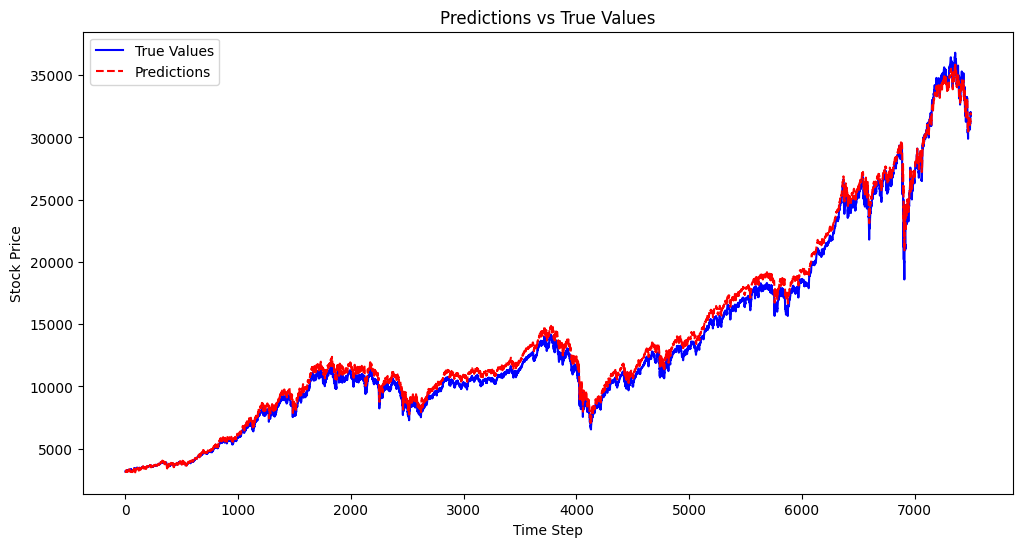

In [155]:
import numpy as np
import matplotlib.pyplot as plt

# Ensure the model is on the correct device
model.to(device)
model.eval()

# Initialize lists to store predictions and true values
predictions = []
true_values = []

# Use the scaler from the dataset
Scaler = dataset.Scaler

with torch.no_grad():  # Disable gradient calculations for testing
    for seq, target in dataloader:
        # Move data to the correct device
        seq, target = seq.to(device).float(), target.to(device).float()

        # Forward pass: Generate the model's predictions
        output = model(seq)  # Shape: (batch_size, output_size)

        # Inverse transform predictions and targets
        output = Scaler.inverse_transform(output.cpu().numpy().reshape(-1, 1)).flatten()
        target = Scaler.inverse_transform(target.cpu().numpy().reshape(-1, 1)).flatten()

        # Append predictions and true values to their respective lists
        predictions.extend(output)
        true_values.extend(target)

# Convert lists to numpy arrays for plotting
predictions = np.array(predictions)
true_values = np.array(true_values)

# Print predictions and true values for verification
print("Predictions:", predictions)
print("True Values:", true_values)
print("Length of Predictions:", len(predictions))
print("Length of True Values:", len(true_values))

# Plot the predictions vs true values
plt.figure(figsize=(12, 6))
plt.plot(true_values, label='True Values', color='blue')
plt.plot(predictions, label='Predictions', color='red', linestyle='--')
plt.title('Predictions vs True Values')
plt.xlabel('Time Step')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


           Close  log_change         7sma        14sma        21sma  \
0    3244.899902    0.006152  3242.071991  3238.786432  3236.079046   
1    3223.399902   -0.006648  3237.395627  3236.642875  3234.764968   
2    3234.100098    0.003314  3236.570641  3236.290737  3234.696926   
3    3272.800049    0.011895  3245.637090  3241.320836  3238.552262   
4    3257.600098   -0.004655  3248.630095  3243.553804  3240.459956   
..           ...         ...          ...          ...          ...   
355  3490.889893    0.000080  3493.826097  3500.107201  3500.689229   
356  3530.199951    0.011198  3502.919561  3504.119568  3503.372022   
357  3518.850098   -0.003220  3506.902195  3506.083638  3504.779120   
358  3516.080078   -0.000788  3509.196666  3507.416497  3505.806480   
359  3510.540039   -0.001577  3509.532509  3507.832969  3506.236803   

         7macd    14macd  
0     2.177613  5.992945  
1    -4.477500  2.630660  
2    -3.328104  1.873715  
3    10.247572  7.084829  
4     9.9957

c:\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-

seq before:            Close  log_change         7sma        14sma        21sma  \
0    3244.899902         NaN          NaN          NaN          NaN   
1    3223.399902   -0.006648          NaN          NaN          NaN   
2    3234.100098    0.003314          NaN          NaN          NaN   
3    3272.800049    0.011895          NaN          NaN          NaN   
4    3257.600098   -0.004655          NaN          NaN          NaN   
..           ...         ...          ...          ...          ...   
366  1205.528687   -0.720483  2639.623465  3005.553312  3153.822133   
367 -2531.528076         NaN  1346.835580  2267.275793  2636.972114   
368          NaN         NaN  1346.835580  2267.275793  2636.972114   
369          NaN         NaN  1346.835580  2267.275793  2636.972114   
370          NaN    0.000000     0.000000     0.000000     0.000000   

           7macd       14macd  
0            NaN          NaN  
1            NaN          NaN  
2            NaN          NaN  
3      

c:\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-

seq before:            Close  log_change        7sma        14sma        21sma  \
0    3244.899902         NaN         NaN          NaN          NaN   
1    3223.399902   -0.006648         NaN          NaN          NaN   
2    3234.100098    0.003314         NaN          NaN          NaN   
3    3272.800049    0.011895         NaN          NaN          NaN   
4    3257.600098   -0.004655         NaN          NaN          NaN   
..           ...         ...         ...          ...          ...   
376          NaN         NaN  1346.83558  2267.275793  2636.972114   
377          NaN         NaN  1346.83558  2267.275793  2636.972114   
378          NaN         NaN  1346.83558  2267.275793  2636.972114   
379          NaN         NaN  1346.83558  2267.275793  2636.972114   
380          NaN    0.000000     0.00000     0.000000     0.000000   

           7macd       14macd  
0            NaN          NaN  
1            NaN          NaN  
2            NaN          NaN  
3            NaN   

c:\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-

seq before:            Close  log_change        7sma        14sma        21sma  \
0    3244.899902         NaN         NaN          NaN          NaN   
1    3223.399902   -0.006648         NaN          NaN          NaN   
2    3234.100098    0.003314         NaN          NaN          NaN   
3    3272.800049    0.011895         NaN          NaN          NaN   
4    3257.600098   -0.004655         NaN          NaN          NaN   
..           ...         ...         ...          ...          ...   
385          NaN         NaN  1346.83558  2267.275793  2636.972114   
386          NaN         NaN  1346.83558  2267.275793  2636.972114   
387          NaN         NaN  1346.83558  2267.275793  2636.972114   
388          NaN         NaN  1346.83558  2267.275793  2636.972114   
389          NaN    0.000000     0.00000     0.000000     0.000000   

           7macd       14macd  
0            NaN          NaN  
1            NaN          NaN  
2            NaN          NaN  
3            NaN   

c:\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-

seq before:            Close  log_change        7sma        14sma        21sma  \
0    3244.899902         NaN         NaN          NaN          NaN   
1    3223.399902   -0.006648         NaN          NaN          NaN   
2    3234.100098    0.003314         NaN          NaN          NaN   
3    3272.800049    0.011895         NaN          NaN          NaN   
4    3257.600098   -0.004655         NaN          NaN          NaN   
..           ...         ...         ...          ...          ...   
396          NaN         NaN  1346.83558  2267.275793  2636.972114   
397          NaN         NaN  1346.83558  2267.275793  2636.972114   
398          NaN         NaN  1346.83558  2267.275793  2636.972114   
399          NaN         NaN  1346.83558  2267.275793  2636.972114   
400          NaN    0.000000     0.00000     0.000000     0.000000   

           7macd       14macd  
0            NaN          NaN  
1            NaN          NaN  
2            NaN          NaN  
3            NaN   

c:\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-

seq before:            Close  log_change        7sma        14sma        21sma  \
0    3244.899902         NaN         NaN          NaN          NaN   
1    3223.399902   -0.006648         NaN          NaN          NaN   
2    3234.100098    0.003314         NaN          NaN          NaN   
3    3272.800049    0.011895         NaN          NaN          NaN   
4    3257.600098   -0.004655         NaN          NaN          NaN   
..           ...         ...         ...          ...          ...   
406          NaN         NaN  1346.83558  2267.275793  2636.972114   
407          NaN         NaN  1346.83558  2267.275793  2636.972114   
408          NaN         NaN  1346.83558  2267.275793  2636.972114   
409          NaN         NaN  1346.83558  2267.275793  2636.972114   
410          NaN    0.000000     0.00000     0.000000     0.000000   

           7macd       14macd  
0            NaN          NaN  
1            NaN          NaN  
2            NaN          NaN  
3            NaN   

c:\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-

seqence_cut before:            Close  log_change         7sma        14sma        21sma  \
239  3262.750000    0.003392  3281.214831  3290.921378  3291.356705   
240  3264.600098    0.000567  3277.061147  3287.411874  3288.924286   
241  3263.600098   -0.000306  3273.695885  3284.236970  3286.622087   
242  3267.899902    0.001317  3272.246889  3282.058695  3284.920070   
243  3271.100098    0.000979  3271.960191  3280.597548  3283.663709   
..           ...         ...          ...          ...          ...   
414          NaN         NaN  1346.835580  2267.275793  2636.972114   
415          NaN         NaN  1346.835580  2267.275793  2636.972114   
416          NaN         NaN  1346.835580  2267.275793  2636.972114   
417          NaN         NaN  1346.835580  2267.275793  2636.972114   
418          NaN         NaN  1346.835580  2267.275793  2636.972114   

           7macd       14macd  
239   -22.208064   -10.141874  
240   -19.074771   -11.863139  
241   -16.513001   -12.926202  

c:\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-

seq before:            Close  log_change        7sma        14sma        21sma  \
0    3244.899902         NaN         NaN          NaN          NaN   
1    3223.399902   -0.006648         NaN          NaN          NaN   
2    3234.100098    0.003314         NaN          NaN          NaN   
3    3272.800049    0.011895         NaN          NaN          NaN   
4    3257.600098   -0.004655         NaN          NaN          NaN   
..           ...         ...         ...          ...          ...   
436          NaN         NaN  1346.83558  2267.275793  2636.972114   
437          NaN         NaN  1346.83558  2267.275793  2636.972114   
438          NaN         NaN  1346.83558  2267.275793  2636.972114   
439          NaN         NaN  1346.83558  2267.275793  2636.972114   
440          NaN    0.000000     0.00000     0.000000     0.000000   

           7macd       14macd  
0            NaN          NaN  
1            NaN          NaN  
2            NaN          NaN  
3            NaN   

c:\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-

seq before:            Close  log_change        7sma        14sma        21sma  \
0    3244.899902         NaN         NaN          NaN          NaN   
1    3223.399902   -0.006648         NaN          NaN          NaN   
2    3234.100098    0.003314         NaN          NaN          NaN   
3    3272.800049    0.011895         NaN          NaN          NaN   
4    3257.600098   -0.004655         NaN          NaN          NaN   
..           ...         ...         ...          ...          ...   
447          NaN         NaN  1346.83558  2267.275793  2636.972114   
448          NaN         NaN  1346.83558  2267.275793  2636.972114   
449          NaN         NaN  1346.83558  2267.275793  2636.972114   
450          NaN         NaN  1346.83558  2267.275793  2636.972114   
451          NaN    0.000000     0.00000     0.000000     0.000000   

           7macd       14macd  
0            NaN          NaN  
1            NaN          NaN  
2            NaN          NaN  
3            NaN   

c:\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-

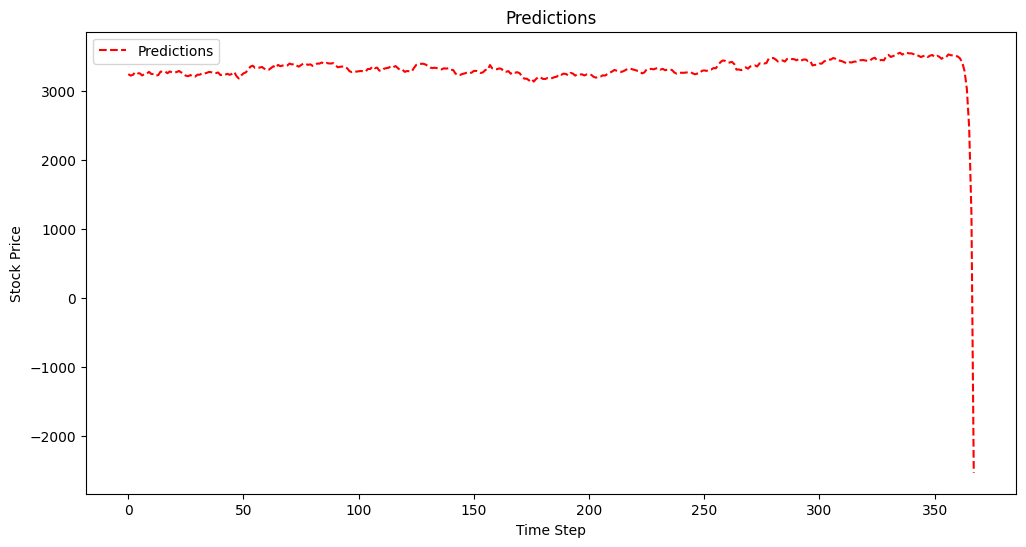

In [156]:
from matplotlib import scale
import numpy as np
import matplotlib.pyplot as plt
from finta import TA

from ta.trend import MACD, EMAIndicator, CCIIndicator
from ta.volatility import BollingerBands, AverageTrueRange
from ta.momentum import RSIIndicator


# Testing loop
model.to(device)  # Move the model to the same device as the input tensors
model.eval()
predictions = []
true_values = []

Scaler = dataset.Scaler
values = sp500[['Close', 'log_change', '7sma', '14sma', '21sma', '7macd', '14macd']]

seq = values.iloc[:SEQ_LEN*2].copy()

def refresh_features(data):
    data['log_change'] = np.log(data['Close'] / data['Close'].shift(1))
    data['7sma'] = EMAIndicator(data['Close'], window=7).ema_indicator()
    data['14sma'] = EMAIndicator(data['Close'], window=14).ema_indicator()
    data['21sma'] = EMAIndicator(data['Close'], window=21).ema_indicator()
    data['7macd'] = MACD(data['Close'], window_slow=11, window_fast=3, window_sign=7).macd()
    data['14macd'] = MACD(data['Close'], window_slow=21, window_fast=7, window_sign=14).macd()


def scale_data(data):
    data['Close'] = Scaler.transform(data['Close'].values.reshape(-1, 1))
    data['7sma'] = Scaler.transform(data['7sma'].values.reshape(-1, 1))
    data['14sma'] = Scaler.transform(data['14sma'].values.reshape(-1, 1))
    data['21sma'] = Scaler.transform(data['21sma'].values.reshape(-1, 1))
    data['7macd'] = Scaler.transform(data['7macd'].values.reshape(-1, 1))
    data['14macd'] = Scaler.transform(data['14macd'].values.reshape(-1, 1))


print(seq)
print("\n")

with torch.no_grad():  # No gradients needed for testing

    # extrapolate the data
    for _ in range(100):  # Number of steps to predict
        # Normalize the current sequence
        seqence_cut = seq.iloc[-SEQ_LEN:].copy()
        print(f"seqence_cut before: {seqence_cut}")

        scale_data(seqence_cut)

        print(f"seqence_cut after: {seqence_cut}")

        sequence_scaled = torch.tensor(seqence_cut.values, dtype=torch.float32).unsqueeze(0).to(device)


        # Predict the next value
        output = model(sequence_scaled)
        next_value_scaled = output.cpu().numpy().flatten()

        # Inverse transform the prediction
        next_value = Scaler.inverse_transform(next_value_scaled.reshape(-1, 1)).flatten()[0]


        # Append the new prediction to the sequence
        seq = pd.concat([seq, pd.DataFrame([[next_value, 0, 0, 0, 0, 0, 0]], columns=seq.columns)], ignore_index=True)

        # Create fetures for the next prediction
        print(f"seq before: {seq}")
        refresh_features(seq)
        print(f"seq after: {seq}")
        
        

# Plot the predictions vs true values
plt.figure(figsize=(12, 6))
plt.plot(seq['Close'], label='Predictions', color='red', linestyle='--')
plt.title('Predictions')
plt.xlabel('Time Step')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

